<a href="https://colab.research.google.com/github/MECAI2022/short_text_classification/blob/main/Pre_treatment_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LightGBM**

In [ ]:
!pip install lightgbm --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 6.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import lightgbm as LGBM
import re
import nltk
from sklearn import feature_extraction, manifold
import re
import os
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from unicodedata import normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def remover_acentos(txt):
    try:
        return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')
    except:
        return np.nan


In [ ]:
filepath = "/content/drive/MyDrive/dataset_produtos.xlsx"
filesave = "/content/drive/MyDrive/"


df = pd.read_excel(filepath)

df = df[df['nm_item'].str.lower()!='nao cadastrado'].reset_index(drop=True)
print(df.columns)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Index(['nm_item', 'segmento', 'categoria', 'subcategoria', 'nm_product'], dtype='object')


In [ ]:
def convert_case(match_obj):
  if match_obj.group(1) is not None:
      match_obj.group(1).replace(' ','')

#Palavras todas minusculas

df['nm_item'] = df['nm_item'].str.lower()

#Remover acentos
df['nm_item2'] = df['nm_item'].apply(remover_acentos)
print('Palavras com acento: ' + str((df['nm_item2']!=df['nm_item']).sum()))

#Remover pontuação
df['nm_item3'] = df['nm_item2'].replace(r'[^\w\s]', ' ',regex=True)
print('Palavras com pontuação: ' + str((df['nm_item3']!=df['nm_item2']).sum()))

# Remover multiplos espaços
df['nm_item4'] = df['nm_item3'].replace(r'\s+', ' ',regex=True)
print('Palavras multiplos espaços: ' + str((df['nm_item4']!=df['nm_item3']).sum()))

#ajustar unidades e dimensao

df['UN_DIM'] = df['nm_item4'].str.extract(r'(\d+kg|\d+mg|\d+ml|\d+km|\d+cm|\d+meia|\d+w[\s\S]*?|\d+v[\s\S]*?|\d+g[\s\S]*?|\d+k[\s\S]*?|\d+l[\s\S]*?|\d+\s+g[\s\S]*?|\d+\s+k[\s\S]*?|\d+\s+kg|\d+\s+mg|\d+\s+ml|\d+\s+meia|\d+\s+km|\d+\s+cm|\d+\s+m[\s\S]*?|\d+\s+v[\s\S]*?|\d+\s+w[\s\S]*?)')
df['UN_DIM2'] = df['nm_item4'].str.extract(r'[\s\S]*?(\bkg)')

df['UN_DIM'] = df['UN_DIM'].fillna(df['UN_DIM2'])

df['VALOR'] = df['UN_DIM'].str.extract(r'(\d+)')
df['UNIDADE'] = df['UN_DIM'].str.extract(r'(\D+)')

df['VALOR'] = df['VALOR'].str.replace(' ','')
df['UNIDADE'] = df['UNIDADE'].str.replace(' ','')

print(len(df))

df_meia = df[df['UNIDADE']=='meia'].reset_index(drop=True)

df_n = df[df['UNIDADE']!='meia'].reset_index(drop=True)

df_meia['UN_DIM2'] = df_meia['nm_item4'].str.extract(r'(\d+kg|\d+mg|\d+ml|\d+km|\d+cm|\d+w[\s\S]*?|\d+v[\s\S]*?|\d+g[\s\S]*?|\d+k[\s\S]*?|\d+l[\s\S]*?|\d+\s+g[\s\S]*?|\d+\s+k[\s\S]*?|\d+\s+kg|\d+\s+mg|\d+\s+ml|\d+\s+km|\d+\s+cm|\d+\s+v[\s\S]*?|\d+\s+w[\s\S]*?)')

df_meia['UN_DIM2'] = df_meia['UN_DIM2'].fillna('meia')

df_meia['VALOR'] = df_meia['UN_DIM2'].str.extract(r'(\d+)')
df_meia['UNIDADE'] = df_meia['UN_DIM2'].str.extract(r'(\D+)')

df_meia['VALOR'] = df_meia['VALOR'].str.replace(' ','')
df_meia['UNIDADE'] = df_meia['UNIDADE'].str.replace(' ','')

df = pd.concat([df_n,df_meia],ignore_index=True)

df['VALOR'] = np.where(df['VALOR'].astype(float)>10000,np.nan,df['VALOR'])

df['UNIDADE2'] = np.where((df['VALOR'].astype(float)<2)&(df['UNIDADE']=='k'),'kg',df['UNIDADE'])

df['VALOR'] = df['VALOR'].fillna('')

df['UN_DIM2'] = np.where((df['VALOR'].isnull())&(df['UNIDADE2']!='meia'),' '+'1'+df['UNIDADE2'].astype(str)+' ',' '+df['VALOR'].astype(str) + df['UNIDADE2'].astype(str)+ ' ')


df['nm_item5'] = df[['nm_item4','UN_DIM','UN_DIM2']].apply(lambda x : x[0].replace(str(x[1]),str(x[2])),axis=1)

# Remover multiplos espaços
df['nm_item6'] = df['nm_item5'].replace(r'\s+', ' ',regex=True)
print('Palavras multiplos espaços: ' + str((df['nm_item6']!=df['nm_item5']).sum()))

# Remover caracteres unicos
df['nm_item7'] = df['nm_item6'].replace(r'\b\D\s\b', '',regex=True)
print('Caracteres únicos: ' + str((df['nm_item7']!=df['nm_item6']).sum()))

df = df.drop(['nm_item2','nm_item3','nm_item5','nm_item6','UN_DIM2','UNIDADE','UN_DIM'],axis=1)


df['UNIDADE2'] = np.where(df['UNIDADE2']=='meia',np.nan,df['UNIDADE2'])

print(len(df))

df['VALOR'] = df['VALOR'].replace('',np.nan)


Palavras com acento: 60
Palavras com pontuação: 37392
Palavras multiplos espaços: 23178
158037
Palavras multiplos espaços: 134506
Caracteres únicos: 26162
158037


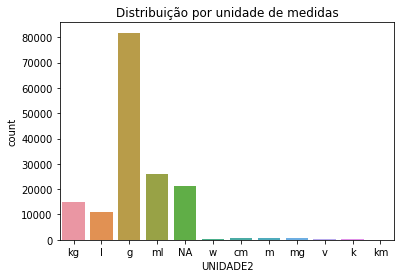

In [ ]:
df2 = df['UNIDADE2'].fillna('NA')

plt.title('Distribuição por unidade de medidas')
sns.countplot(x = df2)


In [ ]:
def utils_preprocess_text(text, flg_stemm=True, flg_lemm=False, lst_stopwords=None):

    lst_text = text.split(' ')
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("portuguese")
print(lst_stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

In [ ]:
df["nm_item7"] = df["nm_item7"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords = lst_stopwords ))

# Remover caracteres unicos
df['texto_treino'] = df['nm_item7'].replace(r'\b\D\s\b', '',regex=True)
print('Caracteres únicos: ' + str((df['nm_item7']!=df['texto_treino']).sum()))


Caracteres únicos: 652


In [ ]:
df[df['nm_item7']!=df['texto_treino']][['nm_item','texto_treino']]

,nm_item,texto_treino
9,abs sempre livre es adp lv16 pgmenos un,ab sempre livre adp lv16 pgmenos un
1189,mant president la motte cs 250g,mant president la motte 250g
1190,mant president ss te 200g,mant president 200g
1448,vela n4 rs kirey,vela n4 kirey
1449,vela n6 rs kirey,vela n6 kirey
...,...,...
156480,cigarro malboro red ks un,cigarro malboro red un
156483,cigarro marlboro double fusion ks rcb,cigarro marlboro double fusion rcb
156751,sabao po surf 5em1 24kgrs/fl lis.,sabao po surf 5em1 24kg fl li
156807,cs calca moletom lisa rajado i22,calca moletom lisa rajado i22


In [ ]:
df['word_count'] = df["texto_treino"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["texto_treino"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["texto_treino"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']
df['VALOR'] = df['VALOR'].astype(float)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

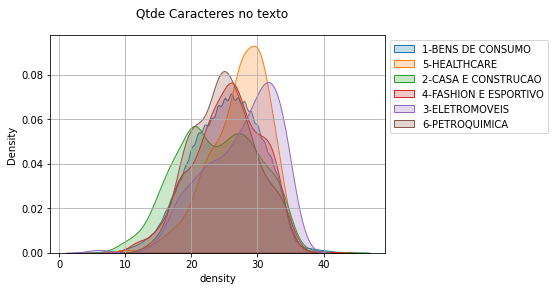

In [ ]:
x, y = "char_count", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Qtde Caracteres no texto', fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

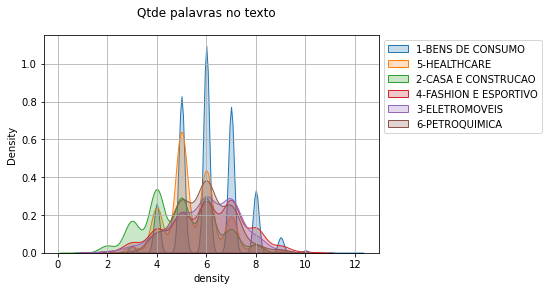

In [ ]:
x, y = "word_count", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Qtde palavras no texto', fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

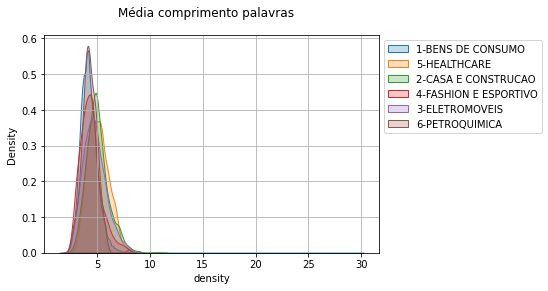

In [ ]:
x, y = "avg_word_length", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Média comprimento palavras', fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

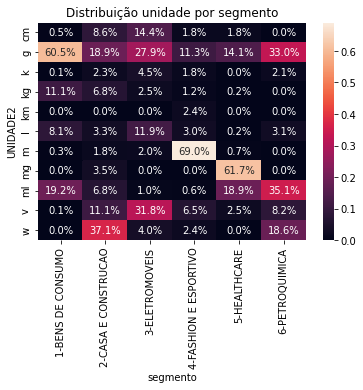

In [ ]:
x, y = "UNIDADE2", "segmento"

base1= pd.crosstab(df['UNIDADE2'],df['segmento']).astype(float)

base1 = (base1/base1.sum()).round(3)

plt.title('Distribuição unidade por segmento')
sns.heatmap(base1,annot=True,fmt = ".1%")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

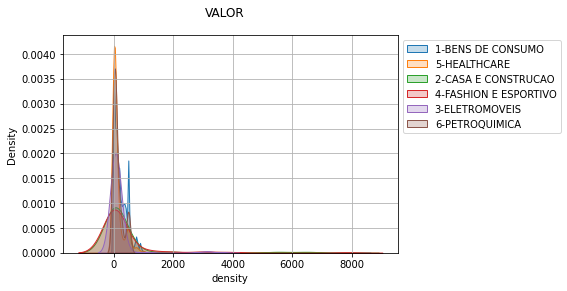

In [ ]:
x, y = "VALOR", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

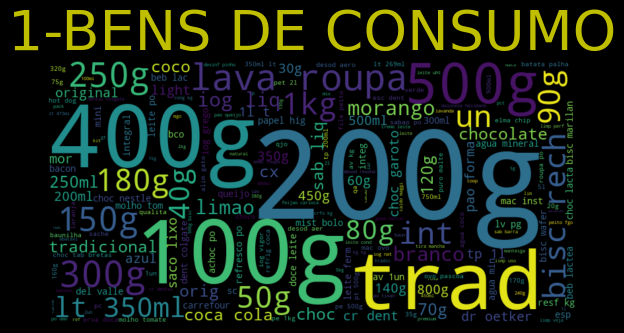

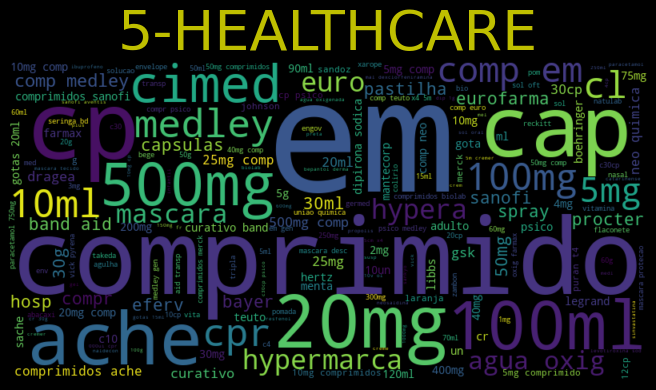

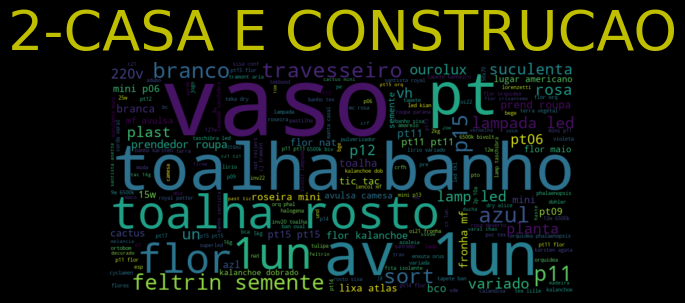

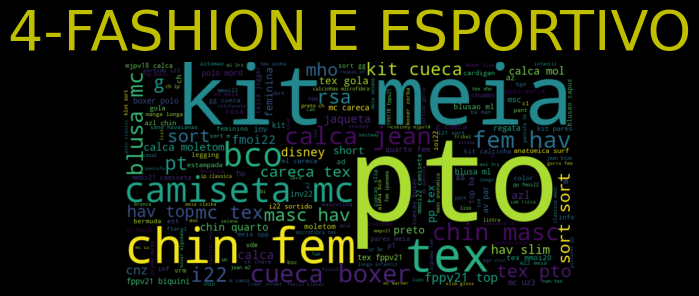

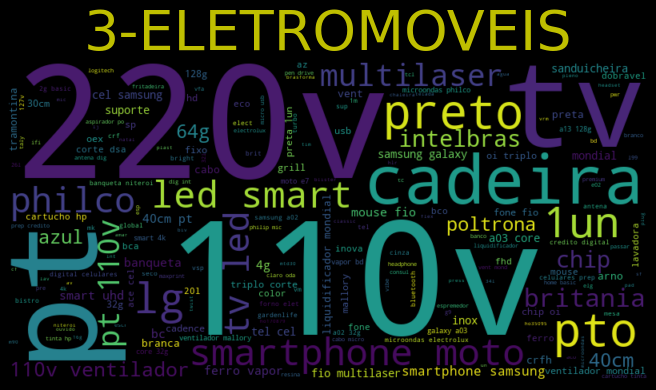

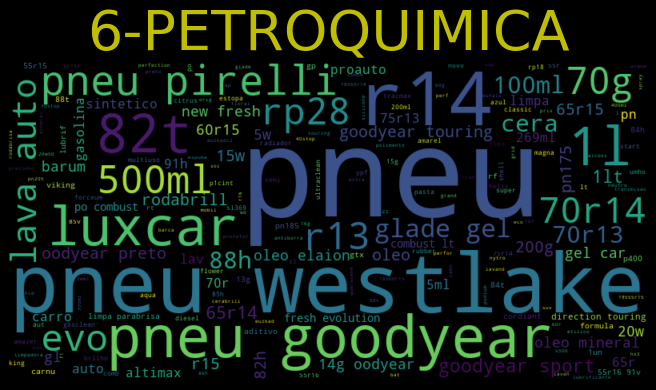

In [ ]:
from wordcloud import WordCloud
import matplotlib as mpl

def cloud(text, title, size=(8,8)):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=800, height=400,
                          background_color='black',
                         ).generate(str(text))
    
   # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()


for y in df['segmento'].unique():

    word = df[df['segmento']==y].reset_index(drop=True)

    word = word['texto_treino'] + ' '

    word_final = word.sum()

    cloud(word_final, title="{}".format(y))



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

# Machine learning e metricas
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import itertools

In [ ]:
tfidfconverter = TfidfVectorizer(max_features=400,min_df=1,max_df=0.95)
X = tfidfconverter.fit_transform(df['texto_treino']).toarray()

In [ ]:
X.shape

(158037, 400)

In [ ]:
# One hot
df['UNIDADE2'] = df['UNIDADE2'].fillna('NA')
df['VALOR'] = df['VALOR'].astype(float)

drop_enc = OneHotEncoder(drop='first',sparse=False)


drop_enc.fit(df[['UNIDADE2']])

cols_hot = drop_enc.transform(df[['UNIDADE2']])

cols_hot = pd.DataFrame(data = cols_hot,columns = drop_enc.get_feature_names_out())

In [ ]:
cols_hot

,UNIDADE2_cm,UNIDADE2_g,UNIDADE2_k,UNIDADE2_kg,UNIDADE2_km,UNIDADE2_l,UNIDADE2_m,UNIDADE2_mg,UNIDADE2_ml,UNIDADE2_v,UNIDADE2_w
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
158032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_vec = pd.DataFrame(data=X,columns=range(1,X.shape[1]+1))

In [ ]:
X_FINAL = pd.concat([X_vec,cols_hot,df[['VALOR','word_count','char_count','avg_word_length']]],axis=1)

le = preprocessing.LabelEncoder()

df['segmento'] = le.fit_transform(df['segmento'])

In [ ]:
def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate) 

#fit_params['callbacks'] = [lgb.reset_parameter(learning_rate=learning_rate_power_0997)]

In [ ]:
LGBM.__version__ 

'3.3.2'

In [ ]:
Xtr, Xtest, ytr, ytest = train_test_split(X_FINAL, df['segmento'], train_size=0.7, random_state = 0, stratify=df['segmento'])

Xtr = Xtr.reset_index(drop=True)
Xtest = Xtest.reset_index(drop=True)
ytr = ytr.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

K=5

kfold = StratifiedKFold(n_splits = K, 
                            random_state = 231, 
                            shuffle = True) 

model_dict={
            'LGBM':{'learning_rate':[0.01], 
                     'early_stopping_rounds':[800],
                     'verbose_eval':[200],
                     'num_boost_round':[80000],
                     'objective':['multiclass'],
                     'num_class': [len(df['segmento'].unique())],
                     'max_depth':[-1],
                     'num_leaves':[10,50,70], 
                     'min_data_in_leaf':[60,75,90,500], 
                    #  'feature_fraction':[0.2,0.3,0.6,0.8], 
                    #  'bagging_fraction':[0.05,0.1,0.5,0.8], 
                     'verbosity':[-1],
                     'metric':['auc_mu'],
                     'seed':[1],
                     'random_state':[3],
                   },
    
                     }

metrics = np.zeros((1,K)) 
for model in model_dict.keys():
    
    for p in itertools.product(*model_dict[model].values()):
        
        model_=eval(model)

        parameters=dict(zip(model_dict[model].keys(),p))

        if model != 'LGBM' and model !='NN': 

            model_=model_(**parameters)

        lr_probs_test = 0

        for i, (f_ind, outf_ind) in enumerate(kfold.split(Xtr, ytr)):
            
            X_train=Xtr.loc[f_ind]
            y_train=ytr.loc[f_ind]


            X_val=Xtr.loc[outf_ind]
            y_val=ytr.loc[outf_ind]
            
            if model =='LGBM':
                
                d_tr, d_valid = train_test_split(X_train.index,
                                                    test_size=.3,random_state=3)


                Xt2,Xv2,yt2,yv2=(X_train.loc[d_tr],
                            X_train.loc[d_valid],
                            y_train.loc[d_tr],
                            y_train.loc[d_valid])
                             
                d_train = LGBM.Dataset(Xt2, label = yt2, 

                                      )

                d_val = LGBM.Dataset(Xv2, label = yv2, 
                                    )

                in_list=['num_boost_round','early_stopping_rounds','verbose_eval']

                parameters_in={x:parameters[x] for x in parameters if x in in_list }

                parameters_out={x:parameters[x] for x in parameters if x not in in_list }


                model_t=model_.train(parameters_out,train_set=d_train,
                              valid_sets =[d_train,d_val],
                              **parameters_in)

                lr_probs_test += model_t.predict(Xtest)

                lr_probs = model_t.predict(X_val)

                lr_probs_t = model_t.predict(X_train)

                metrics[0,i] = roc_auc_score(y_val,lr_probs,average='macro')

                #metrics[1,i] = roc_auc_score(y_train,lr_probs_t,average='macro')

        means = metrics.mean(1)
        deviation = metrics.std(1,ddof=1)
        print('roc_auc_val: %.4f' %(means[0]))

        lr_probs_test = lr_probs_test/K

        y_pred = np.argmax(lr_probs_test,axis=1)


        dict_scores = classification_report(ytest,y_pred, 
                          labels=le.transform(le.classes_) ,target_names=le.classes_,
                          output_dict=True,
                          digits=4)
        
        auc_test = roc_auc_score(ytest,lr_probs_test,average='macro')
        
        print('roc_auc_test: %.4f' %(auc_test))
        print('f1-score_test: %.4f' %(dict_scores['macro avg']['f1-score']))

        results=pd.DataFrame([{'Model':model,
                              'parameters':parameters,
                              'roc_auc':means[1],
                              'roc_auc_std':deviation[1],
                              'roc_auc_train':means[2],
                               'roc_auc_test':auc_test,
                               'f1-score':dict_scores['macro avg']['f1-score'],
                               'recall':dict_scores['macro avg']['recall'],
                               'precision':dict_scores['macro avg']['precision']
                              }])

        final_results=final_results.append(results,ignore_index=True)

        final_results.to_csv(os.path.join(filesave,"LGBM_PARAMETERS.csv"),sep=';',decimal=',',encoding='utf-8',
                      index=False)


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] seed is set=1, random_state=3 will be ignored. Current value: seed=1
Training until validation scores don't improve for 800 rounds
[200]	training's auc_mu: 0.964743	valid_1's auc_mu: 0.921635
[400]	training's auc_mu: 0.975314	valid_1's auc_mu: 0.930422
[600]	training's auc_mu: 0.979401	valid_1's auc_mu: 0.935522
[800]	training's auc_mu: 0.981912	valid_1's auc_mu: 0.938592
[1000]	training's auc_mu: 0.983947	valid_1's auc_mu: 0.9402
[1200]	training's auc_mu: 0.985423	valid_1's auc_mu: 0.941262
[1400]	training's auc_mu: 0.98639	valid_1's auc_mu: 0.942095
[1600]	training's auc_mu: 0.987203	valid_1's auc_mu: 0.942825
[1800]	training's auc_mu: 0.987868	valid_1's auc_mu: 0.943575
[2000]	training's auc_mu: 0.988477	valid_1's auc_mu: 0.943649
[2200]	training's auc_mu: 0.989015	valid_1's auc_mu: 0.943674
